In [444]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import surprise
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic
from surprise import AlgoBase, BaselineOnly
from get_top_n import get_top_n
from surprise.accuracy import rmse, mae

# Set up training & test data

In [445]:
#Load data
dt = pd.read_csv('sample_data.csv',index_col=0)
dt.head()

,reviewerID,productID,rating,date
370183,A2OR4QUQSUMOW7,B0016B9FSU,4.0,2013-01-31
370186,A14E7LZASLSX36,B0016B9FSU,5.0,2013-03-21
370189,A9ESHA5MS6S6L,B0016B9FSU,5.0,2013-01-17
370192,ATATZGNDHA5ZD,B0016B9FSU,5.0,2013-02-05
370193,AN4HRAGRHHX1H,B0016B9FSU,5.0,2013-01-03


In [446]:
#Construct missing ratings we need to predict
select_data = dt.pivot_table('rating',index=['reviewerID','productID'],dropna=False)
select_data = select_data.loc[select_data['rating'].isnull()]
select_data.reset_index(inplace=True)
missing_values = select_data[['reviewerID','productID']].values

In [447]:
reader = Reader(rating_scale=(1,5))
dt = Dataset.load_from_df(dt[['reviewerID','productID','rating']],reader)

In [448]:
raw_ratings = dt.raw_ratings
#Shuffle ratings
random.seed(42)
random.shuffle(raw_ratings)
#Split to training and test sets
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [449]:
dt.raw_ratings = A_raw_ratings  # dt is now the set A
dt.split(n_folds=3)

In [450]:
#Construct train set and test set for use by surprise
trainset = dt.build_full_trainset() # trainset is set A
testset = dt.construct_testset(B_raw_ratings)  # testset is set B

# Train Models

## Baseline Model

In [451]:
#Baseline model: User's bias & item's bias
class BaselineModel(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def compute_bias(self):
        bu = np.zeros(self.trainset.n_users)
        bi = np.zeros(self.trainset.n_items)
        global_mean = self.trainset.global_mean
        
        for i in self.trainset.all_items():
            dev_i = 0
            for (u, r) in self.trainset.ir[i]:
                dev_i += r - global_mean
            bi[i] = dev_i/(len(self.trainset.ir[i]))
        
        for u in self.trainset.all_users():
            dev_u = 0
            for (i, r) in self.trainset.ur[u]:
                dev_u += r - global_mean
            bu[u] = dev_u/(len(self.trainset.ur[u]))
        return bu, bi
    
    def train(self, trainset):
        AlgoBase.train(self, trainset)
        self.bu, self.bi = self.compute_bias()

    def estimate(self, u, i):
        est = self.trainset.global_mean
        if self.trainset.knows_user(u):
            est += self.bu[u]
        if self.trainset.knows_item(i):
            est += self.bi[i]
        return est

algo1 = BaselineModel()

In [452]:
#Train using baseline model and test on testset
evaluate(algo1,dt,measures=['RMSE','MAE'], verbose= 1)
baseline_predictions = algo1.test(testset)

Evaluating RMSE, MAE of algorithm BaselineModel.

------------
Fold 1
RMSE: 1.0403
MAE:  0.7736
------------
Fold 2
RMSE: 1.0510
MAE:  0.7872
------------
Fold 3
RMSE: 1.0457
MAE:  0.7947
------------
------------
Mean RMSE: 1.0457
Mean MAE : 0.7852
------------
------------


In [453]:
#Accuracy on test set
rmse(baseline_predictions)
mae(baseline_predictions)

RMSE: 1.0790
MAE:  0.8137


0.81369601807649294

## Model-based Collaborative Filtering

In [454]:
#SVD
algo2 = SVD()
evaluate(algo2,dt,measures=['RMSE','MAE'], verbose= 1)
svd_predictions = algo2.test(testset)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9505
MAE:  0.7458
------------
Fold 2
RMSE: 0.9418
MAE:  0.7359
------------
Fold 3
RMSE: 0.9283
MAE:  0.7319
------------
------------
Mean RMSE: 0.9402
Mean MAE : 0.7379
------------
------------


In [455]:
#Accuracy on test set
rmse(svd_predictions)
mae(svd_predictions)

RMSE: 0.9699
MAE:  0.7607


0.76071136040273279

#### Changing hyper-parameters of model-based

#Ikya

## KNN Collaborative Filtering

In [456]:
## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
sim_option={'name': 'cosine', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 40 ## The (max) number of neighbors to take into account for aggregation
min_k = 1 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

In [457]:
knn_default = algo_name(k = max_k, min_k = min_k, sim_options=sim_option)

In [458]:
#Train model
perf = evaluate(knn_default, dt, measures=['RMSE','MAE'], verbose= 1)
defaultknn_prediction=knn_default.test(testset)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9879
MAE:  0.7674
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0019
MAE:  0.7671
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9812
MAE:  0.7733
------------
------------
Mean RMSE: 0.9904
Mean MAE : 0.7693
------------
------------


In [459]:
#Accuracy on test set
rmse(defaultknn_prediction)
mae(defaultknn_prediction)

RMSE: 1.0133
MAE:  0.7913


0.79127144257762438

#### Changing hyper-paramater of KNN

In [460]:
algo_name = KNNBasic
#Define the different hyper-paramter range
grid_param = {'k':[20,30,40,50,60],
             'min_k':[1,5,10],
             'sim_options':{'name':['msd','cosine','pearson'],
                           'min_surpport':[0,3,5],
                           'user_based':[False]}
             }

In [461]:
grid_search = surprise.GridSearch(algo_name, grid_param, measures=['RMSE', 'MAE'],verbose = 1)
grid_search.evaluate(dt)

[{'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_o

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1267
Mean MAE : 0.8489
------------
------------
Parameters combination 3 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1267
Mean MAE : 0.8489
------------
------------
Parameters combination 4 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE:

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0414
Mean MAE : 0.8056
------------
------------
Parameters combination 23 of 135
params:  {'k': 20, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0414
Mean MAE : 0.8056
------------
------------
Parameters combination 24 of 135
params:  {'k': 20, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix

Mean RMSE: 1.0452
Mean MAE : 0.8153
------------
------------
Parameters combination 43 of 135
params:  {'k': 30, 'min_k': 5, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0463
Mean MAE : 0.8140
------------
------------
Parameters combination 44 of 135
params:  {'k': 30, 'min_k': 5, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0463
Mean MAE : 0.8140
------------
------------
Parameters combination 45 of 135
params:  {'k'

Parameters combination 62 of 135
params:  {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 63 of 135
params:  {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 64 of 135
params:  {'k': 40, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport

Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0440
Mean MAE : 0.8091
------------
------------
Parameters combination 81 of 135
params:  {'k': 40, 'min_k': 10, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0440
Mean MAE : 0.8091
------------
------------
Parameters combination 82 of 135
params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1284
Mean MAE : 0.85

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0463
Mean MAE : 0.8140
------------
------------
Parameters combination 100 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0331
Mean MAE : 0.7979
------------
------------
Parameters combination 101 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0332
Mean MAE : 0.8033
------------
------------
Parameters combination 120 of 135
params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0332
Mean MAE : 0.8033
------------
------------
Parameters combination 121 of 135
params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean R

In [462]:
grid_search.best_params['RMSE']

{'k': 20,
 'min_k': 10,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [463]:
grid_search.best_score['RMSE']

1.0312498977533373

In [464]:
grid_search.best_params['MAE']

{'k': 20,
 'min_k': 10,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [465]:
grid_search.best_score['MAE']

0.79610249533468036

In [466]:
### get the result of different hyper-parameter

In [467]:
#
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
plotdata = results_df.loc[:,['MAE','RMSE','k','min_k']]
name_list = []
min_surppot_list = []
for param in results_df.params:
#     print(param)
    name_list.append(param['sim_options']['name'])
    min_surppot_list.append(param['sim_options']['min_surpport'])
    
name_list = pd.Series(name_list)
min_surppot_list = pd.Series(min_surppot_list)

plotdata['sim_matric'] = name_list
plotdata['min_support'] = min_surppot_list
plotdata.head()

,MAE,RMSE,k,min_k,sim_matric,min_support
0,0.848934,1.126651,20,1,msd,0
1,0.848934,1.126651,20,1,msd,3
2,0.848934,1.126651,20,1,msd,5
3,0.863714,1.139934,20,1,cosine,0
4,0.863714,1.139934,20,1,cosine,3


In [468]:
plotdata_max_k = plotdata[plotdata.min_k == 1]
plotdata_max_k = plotdata_max_k[plotdata_max_k.min_support == 0]
plotdata_max_k = plotdata_max_k[plotdata_max_k.sim_matric == 'cosine']
plotdata_max_k

,MAE,RMSE,k,min_k,sim_matric,min_support
3,0.863714,1.139934,20,1,cosine,0
30,0.864696,1.140453,30,1,cosine,0
57,0.864973,1.140749,40,1,cosine,0
84,0.864973,1.140749,50,1,cosine,0
111,0.864973,1.140749,60,1,cosine,0


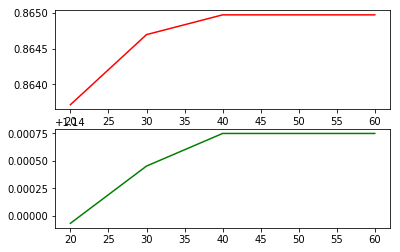

In [469]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_max_k.k, plotdata_max_k.MAE, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_max_k.k, plotdata_max_k.RMSE, 'g')
plt.show()

In [470]:
plotdata_mink = plotdata[plotdata.sim_matric =='cosine']
plotdata_mink = plotdata_mink[plotdata_mink.min_support == 0]
plotdata_mink = plotdata_mink[plotdata_mink.k == 40]
plotdata_mink

,MAE,RMSE,k,min_k,sim_matric,min_support
57,0.864973,1.140749,40,1,cosine,0
66,0.815545,1.045538,40,5,cosine,0
75,0.806868,1.042273,40,10,cosine,0


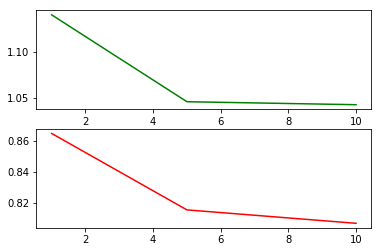

In [471]:
plt.subplot(2, 1, 2) 
plt.plot(plotdata_mink.min_k, plotdata_mink.MAE, 'r')
plt.subplot(2, 1, 1)
plt.plot(plotdata_mink.min_k, plotdata_mink.RMSE, 'g')
plt.show()

In [472]:
plotdata_sim = plotdata[plotdata.min_k <2]
plotdata_sim = plotdata_sim[plotdata_sim.min_support == 3]
plotdata_sim = plotdata_sim[plotdata_sim.k == 40]
plotdata_sim

,MAE,RMSE,k,min_k,sim_matric,min_support
55,0.850682,1.128388,40,1,msd,3
58,0.864973,1.140749,40,1,cosine,3
61,0.875957,1.160948,40,1,pearson,3


# Metrics - Coverage

In [473]:
#Function to calculate coverage ratio
def coverage_ratio(predictions, n):
    top_n = get_top_n(predictions, n)
    product_list = []
    recommended_list = []
    for uid, iid, true_r, est, _ in predictions:
        product_list.append(iid)
    for uid, user_ratings in top_n.items():
        recommended_list.append(user_ratings[0][0])
    coverage = float(len(set(recommended_list))) / float(len(set(product_list)))
    return coverage

In [474]:
#Function to predict missing values based on an algorithm
def mv_prediction(algo,missing_values):
    predictions = [algo.predict(uid, iid)
                       for (uid, iid) in missing_values]
    return predictions

SVD Coverage Ratio

In [475]:
mv_svdprediction = mv_prediction(algo2,missing_values)
coverage_ratio(mv_svdprediction,7)

0.21428571428571427

KNN Coverage ratio

In [476]:
mv_knnprediction = mv_prediction(knn_default,missing_values)
coverage_ratio(mv_knnprediction,7)

0.2857142857142857